<a href="https://colab.research.google.com/github/rahul-punia/py/blob/master/Brain_Tumor_fnl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [ ]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip -uq "/content/drive/My Drive/brain_tumor_dataset_fnl" -d "/content/drive/My Drive/PATH_TO_OUTPUT_fnl"

Mounted at /content/drive


In [ ]:
!apt-get install tree
clear_output()

!mk dir '/content/drive/My Drive/Divide3' 

!mkdir '/content/drive/My Drive/Divide3/TEST3/' '/content/drive/My Drive/Divide3/TRAIN3/' '/content/drive/My Drive/Divide3/TEST3/YES' '/content/drive/My Drive/Divide3/TEST3/NO' '/content/drive/My Drive/Divide3/TRAIN3/YES' '/content/drive/My Drive/Divide3/TRAIN3/NO' 
!mkdir '/content/drive/My Drive/Divide3/VAL3/' '/content/drive/My Drive/Divide3/VAL3/YES' '/content/drive/My Drive/Divide3/VAL3/NO'
clear_output()
!tree -d '/content/drive/My Drive/Divide3'

/content/drive/My Drive/Divide3
├── TEST3
│   ├── NO
│   └── YES
├── TRAIN3
│   ├── NO
│   └── YES
└── VAL3
    ├── NO
    └── YES

9 directories


In [ ]:

IMG_PATH = '/content/drive/My Drive/PATH_TO_OUTPUT_fnl/brain_tumor_dataset_fnl'

# split the data by train/val/test  #/content/drive/My Drive/PATH_TO_OUTPUT/brain_tumor_dataset/no
for CLASS in os.listdir(IMG_PATH):

    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH+'/'+ CLASS))

        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH+'/'+ CLASS)):
                  img = IMG_PATH+'/' + CLASS + '/' + FILE_NAME
                  # print(IMG_NUM)
                  if n < 5:
                      shutil.copyfile(img, '/content/drive/My Drive/Divide3/TEST3/' + CLASS.upper() + '/' + FILE_NAME)
                  elif n < 0.8*IMG_NUM:
                      shutil.copyfile(img, '/content/drive/My Drive/Divide3/TRAIN3/'+ CLASS.upper() + '/' + FILE_NAME)
                  else:
                      shutil.copyfile(img, '/content/drive/My Drive/Divide3/VAL3/'+ CLASS.upper() + '/' + FILE_NAME)

In [ ]:
#define function to load data 
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = [] #array
    y = []
    i = 0 #variable
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path #Store  yes and No 
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X) #make as numpy array so that to perform multiple methods on np rray
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [ ]:
#define function to plot confusion matrix

def confusion_mat(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    cut = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cut else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
TRAIN_DIR = '/content/drive/My Drive/Divide3/TRAIN3/'
TEST_DIR = '/content/drive/My Drive/Divide3/TEST3/'
VAL_DIR = '/content/drive/My Drive/Divide3/VAL3/'
IMG_SIZE = (224,224)
# from tensorflow.keras.datasets.mnist.load_data import load_data
# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

print(labels)
# for val in y_train:
#   print(val)

 50%|█████     | 1/2 [00:00<00:00,  7.07it/s]

193 images loaded from /content/drive/My Drive/Divide3/TRAIN3/ directory.
10 images loaded from /content/drive/My Drive/Divide3/TEST3/ directory.


100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

50 images loaded from /content/drive/My Drive/Divide3/VAL3/ directory.
{0: 'NO', 1: 'YES'}


In [ ]:
#prerequiste function to implement iplot()
def conf_plot_brwsr():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

conf_plot_brwsr()
init_notebook_mode(connected=False)

y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

#print(y)

instance0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='green'),#'#33cc33'-'green'
    opacity=0.7
)
instance1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='red'),#'#ff3300'
    opacity=0.7
)
data = [instance0, instance1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)


iplot(fig);

In [ ]:
def plotting_smpls(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][0:n]  # X[np.argwhere(y == index)] contain all yes or no Images then we slice array 1:n where n=10;
        j = 10
        i = int(n/j)  #i=3

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0]) #plt.imageshow

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

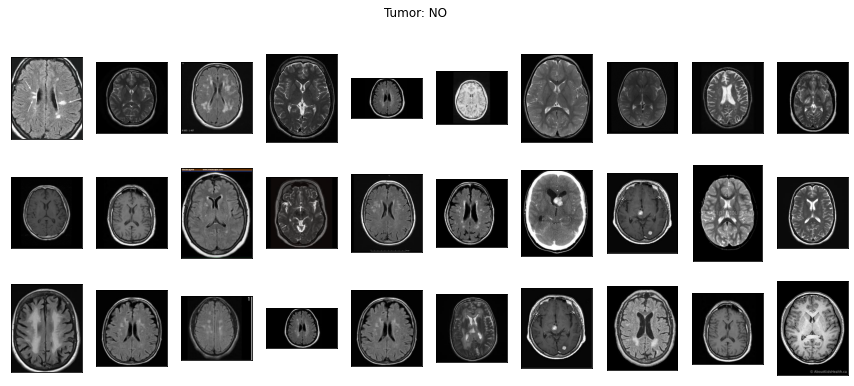

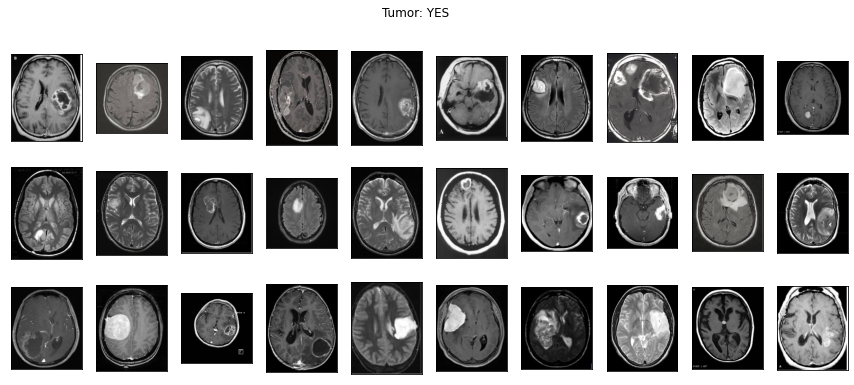

In [ ]:
plotting_smpls(X_train, y_train, labels, 30)

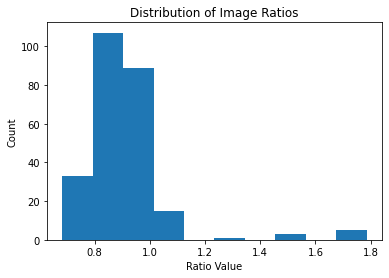

In [ ]:
ratios = []
for set in (X_train, X_test, X_val):
    for img in set:
        ratios.append(img.shape[1]/img.shape[0])
        
plt.hist(ratios)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [ ]:
#Data Preprocessing => Normalization
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        grey = cv2.cvtColor(img, cv2.COLOR_RGB2grey)
        grey = cv2.GaussianBlur(grey, (5, 5), 0)

        # cutold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        cut = cv2.cutold(grey, 45, 255, cv2.cut_BINARY)[1]
        cut = cv2.erode(cut, None, iterations=2)
        cut = cv2.dilate(cut, None, iterations=2)

        # find contours in cutolded image, then grab the largest one
        cnts = cv2.findContours(cut.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [ ]:

img = cv2.imread('/content/drive/My Drive/PATH_TO_OUTPUT_fnl/brain_tumor_dataset_fnl/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
grey = cv2.cvtColor(img, cv2.COLOR_RGB2grey)
grey = cv2.GaussianBlur(grey, (5, 5), 0)

# cutold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
cut = cv2.cutold(grey, 45, 255, cv2.cut_BINARY)[1]
cut = cv2.erode(cut, None, iterations=2)
cut = cv2.dilate(cut, None, iterations=2)

# find contours in cutolded image, then grab the largest one
cnts = cv2.findContours(cut.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

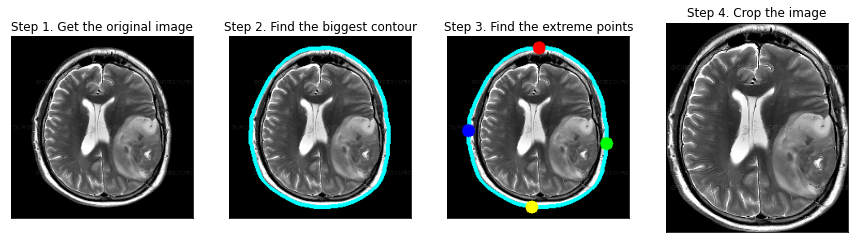

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [ ]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

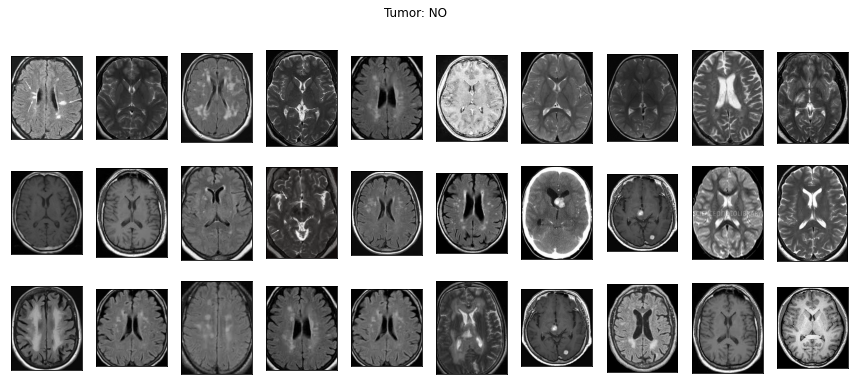

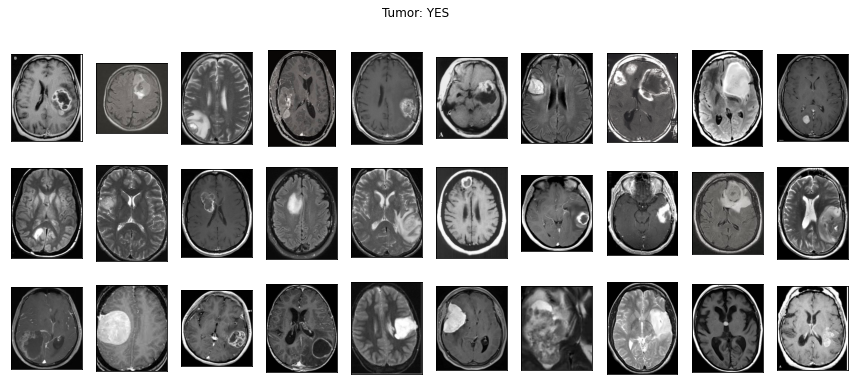

In [ ]:
plotting_smpls(X_train_crop, y_train, labels, 30)

In [ ]:
def save_latest_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [ ]:
# saving new images to the folder
!mkdir '/content/drive/My Drive/TRAIN_CROP3' '/content/drive/My Drive/TEST_CROP3' '/content/drive/My Drive/VAL_CROP3' '/content/drive/My Drive/TRAIN_CROP3/YES' '/content/drive/My Drive/TRAIN_CROP3/NO' '/content/drive/My Drive/TEST_CROP3/YES' '/content/drive/My Drive/TEST_CROP3/NO' '/content/drive/My Drive/VAL_CROP3/YES' '/content/drive/My Drive/VAL_CROP3/NO'

save_latest_images(X_train_crop, y_train, folder_name='/content/drive/My Drive/TRAIN_CROP3/')
save_latest_images(X_val_crop, y_val, folder_name='/content/drive/My Drive/VAL_CROP3/')
save_latest_images(X_test_crop, y_test, folder_name='/content/drive/My Drive/TEST_CROP3/')

mkdir: cannot create directory ‘/content/drive/My Drive/TRAIN_CROP3’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/TEST_CROP3’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/VAL_CROP3’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/TRAIN_CROP3/YES’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/TRAIN_CROP3/NO’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/TEST_CROP3/YES’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/TEST_CROP3/NO’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/VAL_CROP3/YES’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/VAL_CROP3/NO’: File exists


In [ ]:
def image_preprocessing(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [ ]:
X_train_prep = image_preprocessing(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = image_preprocessing(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = image_preprocessing(set_name=X_val_crop, img_size=IMG_SIZE)

In [ ]:
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [ ]:
!mkdir '/content/drive/My Drive/preview3'
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='/content/drive/My Drive/preview3', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

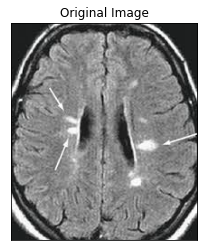

In [ ]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('/content/drive/My Drive/preview3/'):
    img = cv2.cv2.imread('/content/drive/My Drive/preview3/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [ ]:
!rm -rf '/content/drive/My Drive/preview3/'

In [ ]:
TRAIN_DIR = '/content/drive/My Drive/TRAIN_CROP3/'
VAL_DIR = '/content/drive/My Drive/VAL_CROP3/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [ ]:
# Model Buildig
# load base model
vgg16_weight_path = '/content/drive/My Drive/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

In [ ]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
EPOCHS = 450
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=5,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/450
5/5 [==============================] - 76s 15s/step - loss: 5.2489 - accuracy: 0.5116 - val_loss: 2.4527 - val_accuracy: 0.7000
Epoch 2/450
5/5 [==============================] - 50s 10s/step - loss: 4.7568 - accuracy: 0.6202
Epoch 3/450
5/5 [==============================] - 66s 13s/step - loss: 4.5845 - accuracy: 0.6279
Epoch 4/450
5/5 [==============================] - 70s 14s/step - loss: 4.7735 - accuracy: 0.5688
Epoch 5/450
5/5 [==============================] - 67s 13s/step - loss: 4.2695 - accuracy: 0.5814
Epoch 6/450
5/5 [==============================] - 52s 10s/step - loss: 4.6687 - accuracy: 0.6279
Epoch 7/450
5/5 [==============================] - 66s 13s/step - loss: 3.8334 - accuracy: 0.6512
Epoch 8/450
5/5 [==============================] - 51s 10s/step - loss: 4.4965 - accuracy: 0.5891
Epoch 9/450
5/5 [==============================] - 66s 13s/step - loss: 3.4983 - accuracy: 0.7063


In [ ]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]
#y_val array contain labels yes or no as 0 or 1 ex-[0,0,0,1,1]
accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = confusion_mat(confusion_mtx, classes = list(labels.items()), normalize=False)

Val Accuracy = 0.90


Test Accuracy = 0.80


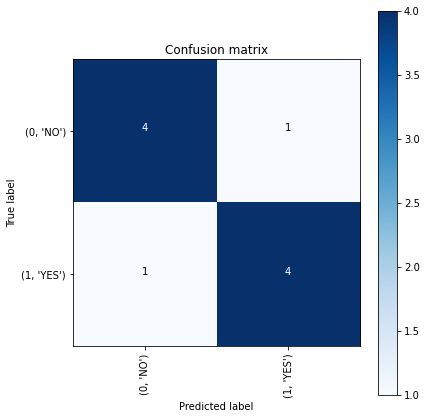

In [ ]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = confusion_mat(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
# ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
# if ind_list.size == 0:
#     print('There are no missclassified images.')
# else:
#     for i in ind_list:
#         plt.figure()
#         plt.imshow(X_test_crop[i])
#         plt.xticks([])
#         plt.yticks([])
#         plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
#         plt.show()

In [ ]:
# clean up the space
# !rm -rf TRAIN TEST VAL TRAIN_CROP TEST_CROP VAL_CROP
# # save the model
# model.save('2020-11-02_VGG_model.h5')